<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" width=300></td>
# <center>Basics of mobile robotics</center>
<img src="image_top_view.png" width=800></td>
### <center> Group 20 </center>
## <center> Benavides Nathan, Dulex Xavier, Mina Jason, Robyr Laly</center>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:center">
Final report for the project of "basics of mobile robotics" given by Prof. Francesco Mondada.</p>
<hr style="clear:both">

# Introduction
<p></p>
<div style="text-align: justify">
$\;\;\;\;\;\;$
To begin with, this project was about programming the Thymio robot so that it navigates on a chosen map with obstacles and reaches two different goals one after the other. There are five main modules implemented in the program: the vision which uses the camera to detect the map, the robot and the fixed obstacles, the global navigation which calculates the shortest path to the goals through the fixed obstacles, the local navigation which allows the Thymio to avoid new obstacles that may obstruct its path, the Kalman filter which estimates the Thymio's position, and the motion control which corrects the speed and the orientation. 
</div>
<p></p>
<div style="text-align: justify">
$\;\;\;\;\;\;$
For the environment, the background used is a large sheet of white paper of $100$ x $140$ cm. Then, one uses colors detection by the camera and an airtag on the Thymio to detect the different elements on the map. Also, the new obstacles for the local navigation are white like the background to avoid the camera to detect it with its colors detection and circular to have a smoother avoidance from the robot. The map setup consists of different components to simulate a city with different buildings acting as the obstacles, a source target from which the delivery of the object is to be picked up, a target goal to which it is to be delivered, and the borders of the city which the delivery guy, the Thymio, cannot pass. The source and destination addresses are represented by green squares, where the smaller square represents the source. The map is represented by the white space with the borders being the ends of the white space, and the vertices of the map are the yellow squares. The buildings or obstacles are represented as the blue squares, and the delivery guy is represented by the Thymio. The complete setup is represented below.
</div>
<p></p>
<div style="text-align: justify">
$\;\;\;\;\;\;$
In the following, one will first go through each module in more details. Secondly, one will have a general approach of the whole program and how the different modules interact with each other. In the end, a section is reserved to run the overall code. 
</div>

<img src="Map_setup.jpeg" width=250>

## Vision

<div style="text-align: justify">
$\;\;\;\;\;\;$The steps of constructing the global map using classical computer vision techniques consist of two steps: an initialization phase and the stage in the loop.

Initialization Phase:

   1. Capturing one image using opencv of the whole setup.
   2. Transforming the image to HSV Space where the detection of colored objects becomes easier.
   3. Applying a Bilateral filter to the image to eliminate noise while preserving the edges.
   4. Applying a yellow mask to the HSV image to detect the corners which will be used to transform it to a top-view image (known as Birds-Eye view). Since the dimensions of the map are known (1000x1400 mm), the transformation is done such that each pixel in the transformed image corresponds to 1 mm on the map, this will make measurements accurate.
   5. Applying to the transformed image a green mask to detect the goals.
   6. Applying blue mask to detect the obstacles.
   7. Dilating the obstacles by half the Thymio radius.
   8. Finally, saving the position of the obstacles, goals, and corners in memory to use them in the loop thus saving processing time instead of detecting them everytime.
   
Loop Phase:

   1. Transforming the image into Birds Eye using the saved corner coordinates.
   2. Detecting the Thymio position and direction using the airtag (chosen for its robustness for detecting the position and direction of the Thymio), using the Aruco library from open cv.
    
### Mapping Steps

- **First Stage**

1 - Read image, convert to HSV and bilateral filtering 

Text(0.5, 1.0, 'Image from the camera')

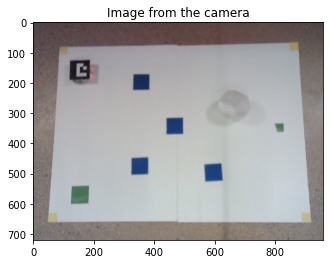

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mapInit import vision

image=cv2.imread("image.png")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image from the camera")

Text(0.5, 1.0, 'Filtered Image in HSV color space')

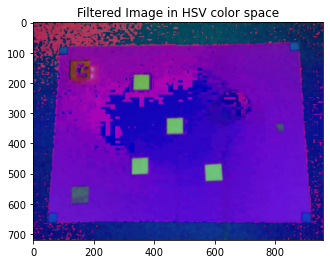

In [2]:
Image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
Image_filtered = cv2.bilateralFilter(Image_HSV, 9, 80, 80)
plt.imshow(Image_filtered)
plt.title("Filtered Image in HSV color space")

2- Detect corners

Text(0.5, 1.0, 'Yellow_Mask_Detection')

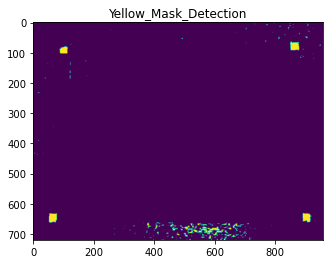

In [3]:
Detect_Yellow = cv2.inRange(Image_HSV, vision.Yellow_Lower,
                            vision.Yellow_Upper)
plt.imshow(Detect_Yellow)
plt.title("Yellow_Mask_Detection")

3- Initialize Birds Eye view by checking validity of corners and saving them in predefined points

<img src="image_top_view.png" width=300>

4- Detect blue obstacles

Text(0.5, 1.0, 'Blue_Mask_Detection')

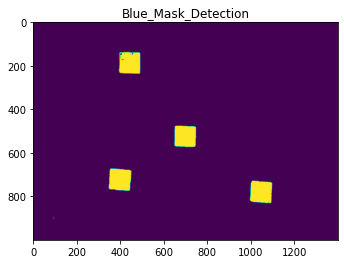

In [4]:
image=cv2.imread("image_top_view.png")
Birds_Eye_image_HSV=cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
Detect_Blue = cv2.inRange(Birds_Eye_image_HSV,
                          vision.Lower_Blue, vision.Upper_Blue)
plt.imshow(Detect_Blue)
plt.title("Blue_Mask_Detection")

5- Detect green goals

Text(0.5, 1.0, 'Green_Mask_Detection')

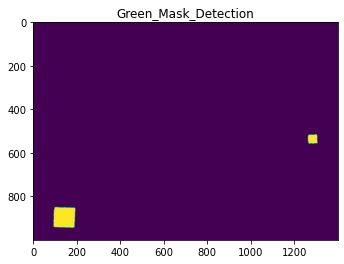

In [5]:
Detect_Green = cv2.inRange(Birds_Eye_image_HSV, 
                           vision.Lower_Green, vision.Upper_Green)
plt.imshow(Detect_Green)
plt.title("Green_Mask_Detection")

6 - Detect Thymio, goals and enlarge obstacles
<img src="thy_image_vis.png" width=300>

- **Second Stage**


Detection of the Thymio, display the path and the next goal :
<img src="detect_th_vis.png" width=300>

## Global Navigation

### Principle

<p></p> 
<def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$Once the vision part has established the map of the environement and extracted the positions of the Thymio, the obstacles and the goals, the path has to be computed in order to move to the wanted position while avoiding the obstacles.

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$For our project, we decided to use the visibility graph approach. This approach consists of marking all corners of the obstacles present on the map and tracing a route between all corners that are visible to each other, i.e. corners whitout obstacles inbetween. Once the visibility graph including all the possible routes is created, the sorthest path from start to finish is computed using the Dijkstra algorithm along these routes considering the real distance between the vertices. The choice for the visibility graph approach was made in order to have the most direct path between the obstacles whitout decomposing the whole map into cells wich would be necessary with a cell decomposition approach. This also allows us to have routes in every direction and therefore a shorter path to the goal, than with a grid based map constraining the movement in the X and Y directions for example. However, as the visibility graph uses the corners of the obstacles to compute the path to follow, it requires to grow the obstacles by half the radius of the robot in order to avoid the obstacles correctly.

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$To implement the shortest path computation using a visibility graph, we used the open-source python package called "Pyvisgraph - Python Visibility Graph". This package computes the visibility graph of a map given a list of polygons, in our case representing the obstacles. The visibility graph is computed using the Lee algorithm, and then computes the shortest path along the possible routes using the Dijkstra algorithm.

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$As we defined our project as a "delivery robot", the Thymio first has to go to the first point to take the package to deliver (small green square on the map) and then to the delivery point (big green square on the map), the path has to be computed in two parts. We first compute the shortest way from the current position of the Thymio to the pick-up place, and then the shortest way from the pick-up point to the delivery point. When both paths are computed, we merge them into one list of coordinates to follow, representing the complete path from the initial position of the Thymio to the final goal, shown in pink on the following images. The two paths are computed on the same visibility graph as the setup doesn't change, therefore minimizing the calculation cost. 

### Results

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$When testing our projet with different configurations of the obstacles and goals, we obtained consistant results for the path to follow. Two different situations are shown in the following images, both resulting in the effective shortest path to the first and second goals while avoiding the obstacles.

Situation 1               |  Situation 2
:-------------------------:|:-------------------------:
<img src="pathimage.png" width=500>  |  <img src="pathimage2.png" width=500>


## Local navigation
<p></p>
<div style="text-align: justify">  
$\;\;\;\;\;\;$
In the local navigation module, as soon as the Thymio detects something over a certain threshold, it adapts the speed given to the two motors to avoid it. As measured in the solution of the fourth week's exercises (see the table below), the Thymio can detect an obstacle at a distance between $3$ and $13$ cm. The Thymio enters the avoidance state as soon as an objet is at about $10$ cm which allows the robot to avoid it without detecting obstacles that are too far and not disturbing its path. Therefore, the avoidance threshold is set at $2200$. Also, the latter is decided low because of the airtag on the Thymio which is larger than the robot itself.</div> <p></p>

<img src="TableDistance.png" alt="Distance" width="350"/>

<div style="text-align: justify"> 
$\;\;\;\;\;\;$
The value of speed given to the motors when the Thymio avoids an obstacle depends on three things: the current speed, the value detected by the horizontal sensors and a certain adapted gain. Indeed, using the detected value by the sensors allows the Thymio to accelerate proportionnally to the distance to the obstacle: thus, the speed adjustment is stronger for a closer object. </div> <p></p>

<div style="text-align: justify"> 
$\;\;\;\;\;\;$
Then, it is still necessary to accelerate or to slow down the motor correctly, depending whether the obstacle is on the right or on the left, which is why one uses differents gains: $[5, 3, -7, -4, -6]$. The positive values are multiplied to the sensed value in the same direction as where the obstacle is and the negative gains are multiplied to the same sensed value and added to the opposite wheel, which together allows the Thymio to turn and avoid the obstacle. The gains aren't symetrical in order for the Thymio to choose one side when it's avoiding something in front of it. Also, the middle gain is negative so that it will move back if something is right in front of it. </div> <p></p>

<div style="text-align: justify"> 
$\;\;\;\;\;\;$
However, as the sensed value is really high compared to the mean speed of $100$, it is necessary to scale the total gain. Therefore, the latter is divided by a chosen value of $500$ in order to add or substract at least more or less one tenth of the mean speed to the current one and at most more or less two thirds of it. </div> <p></p>
$ Maximal\ speed\ gain = \frac{MaxSensedVal\cdot MaxGain}{500} = \frac{5000\cdot (-7)}{500} = -70$ <p></p>
$ Minimal\ speed\ gain = \frac{MinSensedVal\cdot MinGain}{500} = \frac{2200\cdot 3}{500} = 13.2$ <p></p>

<div style="text-align: justify"> 
$\;\;\;\;\;\;$
Once the Thymio passed the obstacle, the speed given to the motors is corrected through the motion control and added to the mean speed. 
</div>
<p></p>

## Motion Control
<p></p>
<div style="text-align: justify"> 
$\;\;\;\;\;\;$
For the motion control, we have decided to implement a P controller with a constant value Kp tuned experimentally of $Kp=100$. Then, to correct the speed applied to the motors we use the error between the Thymio angle and the goal angle. We noticed that a P controller gives a sufficient corrected value so that there is no need to implement a full PID.
</div>
<p></p>

## Filtering
<p></p>

<div style="text-aline : justify">
$\;\;\;\;\;\;$For the filtering we choose to use a Kalman filter. Since the vision can initialise it with a good precision, it's the best choice for our application. For the Kalman filter we select the simple version of it, so that we have more control on each parameter.
<p></p>
    
### Model
    
<p></p>
<div style="text-aline : justify">
$\;\;\;\;\;\;$The model on the kalman is :
<p></p>
$$ x^+ = A \cdot x $$
<p></p>
With :
<p></p>   
$$ A =
\begin{pmatrix}
1 & Ts & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & Ts & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & Ts\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{pmatrix} \qquad \text{and} \qquad x = 
\begin{pmatrix}
\text{x position}\\
\text{x speed}\\
\text{y position}\\
\text{y speed}\\
\text{angle}\\
\text{angular velocity}\\
\end{pmatrix} = 
\begin{pmatrix}
p_x\\
v_x\\
p_y\\
v_y\\
p_{\theta}\\
v_{\theta}\\
\end{pmatrix}$$

<p></p>
<div style="text-aline : justify">
$\;\;\;\;\;\;$For the input measurements of the Kalman we have the position and the speed of the Thymio. The position of the Thymio is given by the vision. For its speed, we calculate it thanks to the speed of the motors using this transformation :
<p></p>
$$ v_x = k_v \cdot \frac{v_r + v_l}{2} \cos(p_{\theta}) \qquad v_y = k \cdot \frac{v_r + v_l}{2} \sin(p_{\theta}) \qquad v_{\theta} = k_w \cdot (v_r - v_l)$$
<p></p>
with $v_r$ and $v_l$ the speed of the right and the left motor respectively and $k_v$ a constant that passes from Thymio speed to linear speed in [mm/s] and $k_w$ a constant that passes from Thymio speed to angular speed in [rad/s].
<p></p>

### Tuning of the parameters
<p></p>    
$\;\;\;\;\;\;$On the Kalman filter there are several important parameters to tune. Firstly, we have to tune the two constants $k_v$ and $k_w$. In order to do that, we let the Thymio go at a certain speed target for a certain time. Then, we can record the speed of the motors as a function of time and measure the distance covered by the Thymio. With that we can find easily the two speed constants.
<p></p>    
$\;\;\;\;\;\;$We need to compute some other parameters to make the Kalman works such as the variance of the different states and the one of the measurements. To compute the variance of the motor speed, we let the Thymio go at a certain speed target for a long time and record the speed of the motors as a function of time. Then, we compute the variance on a part where the speed is constant (we trimed the start and end of the curve). For the position measurement, we made a large number of position measurements with the vision when the Thymio was static and we took the variance. So at the end we end up with those two matrices $Q$ and $R$
<p></p>
$$ Q =
\begin{pmatrix}
0.1 & 0 & 0 & 0 & 0 & 0\\
0 & 6.15 & 0 & 0 & 0 & 0\\
0 & 0 & 0.1 & 0 & 0 & 0\\
0 & 0 & 0 & 6.15 & 0 & 0\\
0 & 0 & 0 & 0 & 0.01 & 0\\
0 & 0 & 0 & 0 & 0 & 0.13\\
\end{pmatrix} $$
    <p></p>
$$ R_{\text{vision}} = 
\begin{pmatrix}
0.1 & 0 & 0 & 0 & 0 & 0\\
0 & 6.15 & 0 & 0 & 0 & 0\\
0 & 0 & 0.1 & 0 & 0 & 0\\
0 & 0 & 0 & 6.15 & 0 & 0\\
0 & 0 & 0 & 0 & 0.01 & 0\\
0 & 0 & 0 & 0 & 0 & 0.13\\
\end{pmatrix} \qquad \text{and} \qquad R_{\text{without vision}} = 
\begin{pmatrix}
0 & 6.15 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 6.15 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0.13\\
\end{pmatrix} $$

## General structure and code

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$ This section shows the final code of the project and the interraction between the differents modules. The execution follows the workflow represented in the following diagramm. Each box of the diagramm is explained in more details in the following sub-sections with the associated code that can be executed.

<img src="general_workflow.png" width=420>

### Imports

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$The first part of the code is responsible to import the modules and packages needed for the execution of our project. The different imported modules are reponsible for the following actions :

- kalman.py : initialize the different parameters needed for the Kalman filter and defines the function to compute the position of the Thymio through a Kalman filter to estimate the position when the vision is blocked.
- mapInit.py : takes the output from the vision module in order to build the initial map, where the Thymio, the obstacles, the goals, and the path to follow is shown.
- local_navigation.py : module responsible for the local avoidance when the robot senses an object in his path.
- vision.py : module responsible for the detection of the Thymio with an airtag, for the detection of the goals and obstacles using color detection, as well as finding the coordinates of these objects on the map. 
- gnav.py : module for the path planning in order to move from the start point to the intermediate goal and the final goal following the shortest path while avoiding the obstacles.

<p></p> <def style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$The camera is then initialized with the needed resolution, and the Thymio is initialized in order to run properly.
    


In [8]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time
import tdmclient.notebook

import kalman
import mapInit
import local_navigation
from mapInit import vision
from mapInit import gnav

from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()

await tdmclient.notebook.start()

vid = cv2.VideoCapture(0)
vid.set(3,1080)
vid.set(4,1920)

True

The next cell displays the video feed from the camera to help adjusting the setup. Press 'q' to leave the page.

In [10]:
while(1):
    ret, image = vid.read()
    if ret == True:

        cv2.imshow('Image', image)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    else:
        break
cv2.destroyAllWindows()

### Map Initialisation
<p style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$ Once all the modules are imported, we can start by initializing the map. The initMap function uses the result from the vision module to display the obstacles, the position and angle of the Thymio, and the path to follow in order to drive to the goals.</p>

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.95it/s]


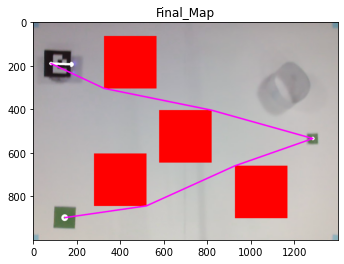

In [11]:
thymio_center, thymio_angle, list_goals = mapInit.map_init(vid)

### Main loop
<p style="font-size:1em; margin:2px; text-align:justify">
$\;\;\;\;\;\;$The main part of the loop is responsible for the step by step control of the Thymio. As shown in the flow diagramm in the beginning of the section, each step executes the following actions : </p>

- update of the position of the Thymio with the vision. If the vision is blocked, the position is set to zero and the Kalman filter is notified with the boolean *is_vision*
- update of the position of the Thymio with the Kalman filter. If the vision is blocked, the estimated position from the Kalman filter (according to the position computed from the motor encoders) is taken into account.
- computing the distance to the next goal through the function *next_goal* from the global navigation module. This function increments the *current_goal* counter if the Thymio is in a radius of 2 centimeters from the center of the goal, or keeps the same *current_goal* if the Thymio is not close enough from the goal. If the next goal is the last goal of the list and the Thymio is close to it, the final goal is achieved and the program finishes.
- once the next goal is known, we can compute the error angle between the direction of the Thymio and the direction given by the goal. This is then fed into a P-controller to guide the Thymio to the next goal.
- ultimately, the local navigation function is called to check if an obstacle is on the planned path. If so, the trajectory is adapted to avoid the obstacle and continue in the direction of the goal.

In [12]:
client = ClientAsync()

work = 1
current_goal = 0
kp = 100
start_time = 0
prev_time = -0.1

thymio_center = []

@tdmclient.notebook.sync_var
def Th_function():
    global Ts, kp, prox_horizontal, motor_left_target, motor_right_target, motor_left_speed, motor_right_speed, vid
    global list_goals, current_goal, thymio_center, start_time, prev_time
    
    start_time = time.time()
    
    ret, image = vid.read()
    frame = vision.Birds_Eye(image)
    
    try:
        thymio_center, thymio_angle, is_vision = vision.find_thymio(frame)
    except :
        is_vision = False
        thymio_center = [0,0]
        thymio_angle = 0
    
    x = kalman.update_position(start_time - prev_time, thymio_center[0], -thymio_center[1], -thymio_angle, is_vision,
                               motor_left_speed, motor_right_speed)
    
    current_goal = gnav.next_goal([x[0], -x[2]], list_goals, current_goal)
    
    if current_goal == -1 :
        return 0
    
    theta_err = kalman.err_angle(x[0], x[2], x[4], list_goals[current_goal][0], -list_goals[current_goal][1])
        
    for i in range(1,len(list_goals)):
        cv2.line(frame, [int(list_goals[i-1][0]), int(list_goals[i-1][1])],
             [int(list_goals[i][0]), int(list_goals[i][1])], (255, 0, 255), 5)
    
    cv2.circle(frame, (int(x[0]), -int(x[2])), 10, (255, 0, 0), -1)
    
    cv2.arrowedLine(frame, (int(x[0]), -int(x[2])),
                ( int(x[0] + 100*np.cos(-x[4])), int(-x[2] + 100*np.sin(-x[4])) ),
                (255, 255, 255), 10)
    
    cv2.circle(frame, (int(list_goals[current_goal][0]), int(list_goals[current_goal][1])), 10, (0, 0, 255), -1)
    cv2.imshow('Image', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'):
        return 0
    
    cl, cr = local_navigation.local_nav(theta_err*kp, -theta_err*kp, theta_err, prox_horizontal)
    
    motor_left_target = int(cl)
    motor_right_target = int(cr)
    
    prev_time = start_time
    
    return 1

ret, image = vid.read()
frame = vision.Birds_Eye(image)
thymio_center, thymio_angle, is_vision = vision.find_thymio(frame)

x_0 = np.array([thymio_center[0], 0, -thymio_center[1], 0, -thymio_angle, 0])
P_0 = np.eye(6, dtype = float)*0.01

kalman.init_kalman(x_0, P_0)

while(work):
    work = Th_function()
    await client.sleep(0.1)
    

cv2.destroyAllWindows()

motor_left_target = 0
motor_right_target = 0

## Conclusion
<p></p>
<div style="text-align: justify">
$\;\;\;\;\;\;$
To conclude, the whole program works and the Thymio is able to find the shortest path to the different goals through the fixed obstacles as well as avoiding new obstacles that appears on its way. The Kalman filter works well too as the robot keeps following the right path even when the vision is obstructed. </div> <p></p>

<div style="text-align: justify">
$\;\;\;\;\;\;$
Eventually, this project really challenged us: indeed, combining very different modules together weren't easy at first. We had to adapt ourselves and change parts of the code that alone were working correctly, but together weren't acting as expected. This project showed us very well how to implement a complex function on a robot, which is essential for the rest of our Master in Robotics.  All in all, we manage to separate the work load between the different group members while helping each other when needed. In the end, we are very satisfied with the final result. 
</div>

# Backup video

https://drive.google.com/file/d/1zp49wTBYymmyM_bepTut9gqiGv6PP8Wu/view?usp=sharing

# Final Program

In [ ]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time
import tdmclient.notebook

import kalman
import mapInit
import local_navigation
from mapInit import vision
from mapInit import gnav

from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()

await tdmclient.notebook.start()

vid = cv2.VideoCapture(0)
vid.set(3,1080)
vid.set(4,1920)

while(1):
    ret, image = vid.read()
    if ret == True:

        cv2.imshow('Image', image)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    else:
        break
cv2.destroyAllWindows()

thymio_center, thymio_angle, list_goals = mapInit.map_init(vid)

In [ ]:
client = ClientAsync()

work = 1
current_goal = 0
kp = 100
start_time = 0
prev_time = -0.1

thymio_center = []

@tdmclient.notebook.sync_var
def Th_function():
    global Ts, kp, prox_horizontal, motor_left_target, motor_right_target, motor_left_speed, motor_right_speed, vid
    global list_goals, current_goal, thymio_center, start_time, prev_time
    
    start_time = time.time()
    
    ret, image = vid.read()
    frame = vision.Birds_Eye(image)
    
    try:
        thymio_center, thymio_angle, is_vision = vision.find_thymio(frame)
    except :
        is_vision = False
        thymio_center = [0,0]
        thymio_angle = 0
    
    x = kalman.update_position(start_time - prev_time, thymio_center[0], -thymio_center[1], -thymio_angle, is_vision,
                               motor_left_speed, motor_right_speed)
    
    current_goal = gnav.next_goal([x[0], -x[2]], list_goals, current_goal)
    
    if current_goal == -1 :
        return 0
    
    theta_err = kalman.err_angle(x[0], x[2], x[4], list_goals[current_goal][0], -list_goals[current_goal][1])
        
    for i in range(1,len(list_goals)):
        cv2.line(frame, [int(list_goals[i-1][0]), int(list_goals[i-1][1])],
             [int(list_goals[i][0]), int(list_goals[i][1])], (255, 0, 255), 5)
    
    cv2.circle(frame, (int(x[0]), -int(x[2])), 10, (255, 0, 0), -1)
    
    cv2.arrowedLine(frame, (int(x[0]), -int(x[2])),
                ( int(x[0] + 100*np.cos(-x[4])), int(-x[2] + 100*np.sin(-x[4])) ),
                (255, 255, 255), 10)
    
    cv2.circle(frame, (int(list_goals[current_goal][0]), int(list_goals[current_goal][1])), 10, (0, 0, 255), -1)
    cv2.imshow('Image', frame)

    if cv2.waitKey(25) & 0xFF == ord('q'):
        return 0
    
    cl, cr = local_navigation.local_nav(theta_err*kp, -theta_err*kp, theta_err, prox_horizontal)
    
    motor_left_target = int(cl)
    motor_right_target = int(cr)
    
    prev_time = start_time
    
    return 1

ret, image = vid.read()
frame = vision.Birds_Eye(image)
thymio_center, thymio_angle, is_vision = vision.find_thymio(frame)

x_0 = np.array([thymio_center[0], 0, -thymio_center[1], 0, -thymio_angle, 0])
P_0 = np.eye(6, dtype = float)*0.01

kalman.init_kalman(x_0, P_0)

while(work):
    work = Th_function()
    await client.sleep(0.1)
    

cv2.destroyAllWindows()

motor_left_target = 0
motor_right_target = 0